In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt

# Preprocessing

In [18]:
f = open("data/shakespear_dataset.txt", "r")
text = f.read()

dictionary = []
for i in text:
    if i not in dictionary:
        dictionary.append(i)
#print(dictionary)

chunk_len = 200
print()
dataset = []
k = 0
for i in range(math.floor(len(text)/chunk_len)):
    word = []
    for j in range(k,k+chunk_len):
        word.append(text[j])
    k += chunk_len
    dataset.append(word)
#dataset = text.split()
#print(dataset)


In [19]:
print(dictionary)

['F', 'i', 'r', 's', 't', ' ', 'C', 'z', 'e', 'n', ':', '\n', 'B', 'f', 'o', 'w', 'p', 'c', 'd', 'a', 'y', 'u', 'h', ',', 'm', 'k', '.', 'A', 'l', 'S', 'Y', 'v', '?', 'R', 'M', 'W', "'", 'L', 'I', 'N', 'g', ';', 'b', '!', 'O', 'j', 'V', '-', 'T', 'H', 'E', 'U', 'D', 'P', 'q', 'x', 'J', 'G', 'K', 'Q', '&', 'Z', 'X', '3']


In [20]:
print(dataset[0])

['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n', '\n', 'A', 'l', 'l', ':', '\n', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n', '\n', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'Y', 'o', 'u', ' ', 'a', 'r', 'e', ' ', 'a', 'l', 'l', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', ' ', 'r', 'a', 't', 'h', 'e', 'r', ' ', 't', 'o', ' ', 'd', 'i', 'e', ' ', 't', 'h', 'a', 'n', ' ', 't', 'o', ' ', 'f', 'a', 'm', 'i', 's', 'h', '?', '\n', '\n', 'A', 'l', 'l', ':', '\n', 'R', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', ' ', 'r', 'e', 's', 'o', 'l', 'v', 'e', 'd', '.', '\n', '\n', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n', 'F', 'i', 'r', 's', 't', ',', ' ', '

In [21]:
def index(x):
    i = 0
    for k in dictionary:
        if x == k:
            return i
        else:
            i += 1

def one_hot(character):
    identity = np.identity(len(dictionary))
    i = index(character)
    one_h = identity[i]
    return np.array(one_h)

In [22]:
x = []
y = []
for xe in dataset:
    ind = len(xe)
    y_word = xe[1:]
    
    x_word = xe[:ind-1]
    x_one_hot = []
    y_one_hot = []
    for xc, yc in zip(x_word, y_word):
        x_one_hot.append(one_hot(xc))
        y_one_hot.append(one_hot(yc))
    x.append(np.array(x_one_hot))
    y.append(np.array(y_one_hot))
x = np.array(x)
y = np.array(y)
print("First word in x:")
print(x[0])
print("First word in y:")
print(y[0])

First word in x:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First word in y:
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, train_size=0.6, random_state=None, shuffle=False, stratify=None)


# Model

In [84]:
rnn = keras.Sequential()
rnn.add(keras.layers.Input(shape=(None, len(dictionary))))
#rnn.add(keras.layers.Embedding(input_dim=len(dictionary), output_dim=2, mask_zero=True))
rnn.add(keras.layers.GRU(600, return_sequences=True))
rnn.add(keras.layers.LSTM(600, return_sequences=True))
rnn.add(keras.layers.Dense(len(dictionary), activation=keras.activations.softmax))
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 600)         1198800   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 600)         2882400   
_________________________________________________________________
dense_3 (Dense)              (None, None, 64)          38464     
Total params: 4,119,664
Trainable params: 4,119,664
Non-trainable params: 0
_________________________________________________________________


# Training

In [85]:
opt = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
rnn.compile(optimizer=opt, 
            loss=loss_fn,
            metrics=['accuracy'])

history = rnn.fit(x=x_train, y=y_train, batch_size=100, epochs=40, validation_split=0.4)

Epoch 1/40
21/21 [==============================] - 84s 4s/step - loss: 4.0849 - accuracy: 0.1000 - val_loss: 3.4019 - val_accuracy: 0.1551
Epoch 2/40
21/21 [==============================] - 102s 5s/step - loss: 3.3698 - accuracy: 0.1313 - val_loss: 3.3301 - val_accuracy: 0.1551
Epoch 3/40
21/21 [==============================] - 88s 4s/step - loss: 3.3241 - accuracy: 0.1508 - val_loss: 3.3196 - val_accuracy: 0.1551
Epoch 4/40
21/21 [==============================] - 86s 4s/step - loss: 3.3188 - accuracy: 0.1508 - val_loss: 3.3140 - val_accuracy: 0.1551
Epoch 5/40
21/21 [==============================] - 86s 4s/step - loss: 3.3069 - accuracy: 0.1508 - val_loss: 3.2960 - val_accuracy: 0.1551
Epoch 6/40
21/21 [==============================] - 85s 4s/step - loss: 3.2843 - accuracy: 0.1508 - val_loss: 3.2660 - val_accuracy: 0.1552
Epoch 7/40
21/21 [==============================] - 88s 4s/step - loss: 3.2199 - accuracy: 0.1510 - val_loss: 3.1672 - val_accuracy: 0.1555
Epoch 8/40
21/21 [=

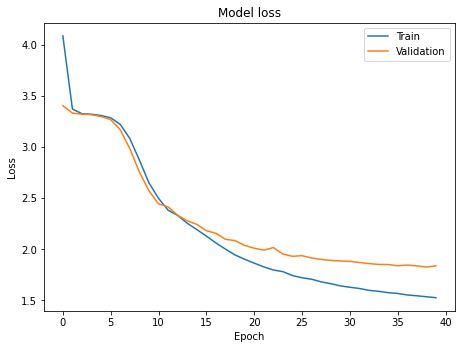

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)

Text(0.5, 0, 'Epoch')

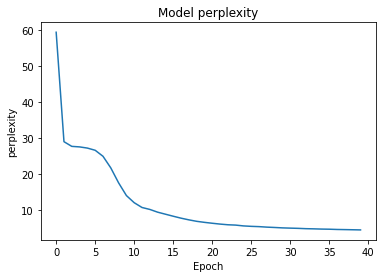

In [87]:
l = history.history["loss"]
exp_loss = tf.exp(l)
plt.plot(exp_loss)
plt.title('Model perplexity')
plt.ylabel('perplexity')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

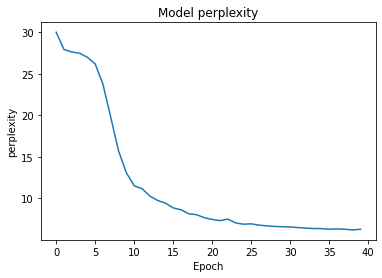

In [88]:
l = history.history["val_loss"]
exp_loss = tf.exp(l)
plt.plot(exp_loss)
plt.title('Model perplexity')
plt.ylabel('perplexity')
plt.xlabel('Epoch')

In [89]:
rnn.evaluate(x_test, y_test)

70/70 [==============================] - 68s 975ms/step - loss: 1.9381 - accuracy: 0.4599


[1.9381409883499146, 0.459883451461792]

In [90]:
def evaluate(model, prime_str, predict_len):
    #model.reset_states(states=[np.zeros((100, nodes)), np.zeros((batch_size, nodes))])
    predicted = prime_str
    #priming
    for char in prime_str:
        one_hot_char = one_hot(char)
        one_hot_char = np.reshape(one_hot_char, (1, 64))
        output = model.predict(np.array([one_hot_char]))
    inp = one_hot(prime_str[-1])
    
    for i in range(predict_len):
        inp = np.reshape(inp, (1, 64))
        output = model.predict(np.array([inp]))
        prediction = dictionary[np.argmax(output)]
        predicted += prediction
        inp = output
    return predicted

In [91]:
import random
def generate_primer(length):
    string = ""
    for i in range(length):
        index = random.randint(0, len(dictionary)-1)
        string += dictionary[index]
    return string

In [92]:
pr = generate_primer(5)
print(pr)
test = evaluate(rnn, pr, 100)
print(test)
print(len(test))

OIzY;
OIzY; TEn Coro o oero o o se o o o o o se o o o o oete o o o oe o o o oere o oete o o o o o se o o o o o 
105


In [93]:
pr = generate_primer(5)
print(pr)
test = evaluate(rnn, pr, 100)
print(test)
print(len(test))

t-hLx
t-hLxpe e o oero o o se o o o o o se o o o o o se o o o o o se o o o o oero o o se o o o o o oe o o o oet
105


In [94]:
pr = generate_primer(5)
print(pr)
test = evaluate(rnn, pr, 100)
print(test)
print(len(test))

pDqEI
pDqEI Go oe o o o oete o o o o oete o o oete o o o o oete o o o o oe o o o o se o o o o o se o o o o se o
105


In [95]:
primers = ["The", "What is", "Shall I give", "XhNYB BHN BYFVuhsdbs"]

In [96]:
for pr in primers:
    print(pr)
    test = evaluate(rnn, pr, 100)
    print(test)
    print(len(test))

The
The o o oete o o o o o se o o o o o se o o o o oe o o o oe o o o o se o o o o o se o o o o oere o o se 
103
What is
What is o oete o o o o o se o o o o oete o o o o o se o o o o o se o o o o o oe o o o o se o o o o o se o o
107
Shall I give
Shall I give o o oete o o o o o se o o o o o se o o o o oe o o o oe o o o o se o o o o o se o o o o oere o o se 
112
XhNYB BHN BYFVuhsdbs
XhNYB BHN BYFVuhsdbs o oete o o o o o se o o o o oete o o o o o se o o o o o se o o o o o oe o o o o se o o o o o se o o
120


In [130]:
print(primers[-1])
test = evaluate(rnn, primers[-1], 100)
print(test)
print(len(test))

XhNYB BHN BYFVuhsdbs
XhNYB BHN BYFVuhsdbs aeeeeeerenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenenene
120


# Word RNN

# Preprocessing

In [3]:
f = open("data/shakespear_dataset.txt", "r")
text = f.read()
wordlist = []
wordlist = text.split()
dictionary = []
for i in wordlist:
    if i not in dictionary:
        dictionary.append(i)
#print(dictionary)

chunk_len = 15
print()
dataset = []
k = 0
for i in range(math.floor(len(wordlist)/chunk_len)):
    sentence = []
    for j in range(k,k+chunk_len):
        sentence.append(wordlist[j])
    k += chunk_len
    dataset.append(sentence)
#dataset = text.split()
print(dataset[0])


['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:']


In [235]:
# def indexing(sentence):
#     indexed = []
#     for word in sentence:
#         ind = dictionary.index(word)
#         indexed.append(ind)
#     return indexed

In [236]:
# new_dataset = []
# for sentence in dataset:
#     indexed_sentence = indexing(sentence)
#     new_dataset.append(indexed_sentence)

In [237]:
# def bow_embedder(sentence, vocab_len):
#     bow = np.zeros(vocab_len)
#     for index in sentence:
#         bow[index] += 1
#     return bow

In [238]:
# for i in range(len(new_dataset)):
#     sentence = new_dataset[i]
#     bow = bow_embedder(sentence, len(dictionary))
#     new_dataset[i] = bow

In [7]:
x = []
y = []
for sentence in dataset:
    x.append(np.array(sentence[:-1]))
    y.append(np.array(sentence[1:]))
x = np.array(x)
y = np.array(y)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, train_size=0.6, random_state=None, shuffle=False, stratify=None)

# Model

In [9]:
rnn = keras.Sequential()
#rnn.add(keras.layers.Input(shape=(None, len(dictionary))))
rnn.add(keras.layers.Embedding(input_dim=len(dictionary), output_dim=64))
rnn.add(keras.layers.GRU(300, return_sequences=True))
rnn.add(keras.layers.LSTM(200, return_sequences=True))
rnn.add(keras.layers.Dense(len(dictionary), activation=keras.activations.softmax))
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1642816   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 300)         329400    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         400800    
_________________________________________________________________
dense_1 (Dense)              (None, None, 25669)       5159469   
Total params: 7,532,485
Trainable params: 7,532,485
Non-trainable params: 0
_________________________________________________________________


In [10]:
opt = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
rnn.compile(optimizer=opt, 
            loss=loss_fn,
            metrics=['accuracy'])

history = rnn.fit(x=x_train, y=y_train, batch_size=100, epochs=40, validation_split=0.4)

Epoch 1/40


ValueError: in user code:

    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    D:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    D:\anaconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 14) and (None, 14, 25669) are incompatible
